# Operations

### Librarias utilizadas

In [35]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt

### Se carga el set de datos

In [19]:
# Poligono de La Union
union=gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_poligono/la_union.shp")
# Dataset de parcelas
parc=gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_parcelas/parcelas.shp")
# Dataset de mineria
miner=gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_mineria/mineria.shp")
# Dataset de suelos
soil=gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_suelos/suelos.shp")
# Dataset de vocacion
voca=gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_vocacion/vocacion.shp")
# Dataset de elevación
elev_path='/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/elevation.tif'
# Dataset de vias
# Dataset de clima

### Afectación Minera de cada parcela

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_3064/3486090307.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  affected_parc = parc[parc.geometry.intersects(mineria_buffered_gdf.unary_union)]
/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_3064/3486090307.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


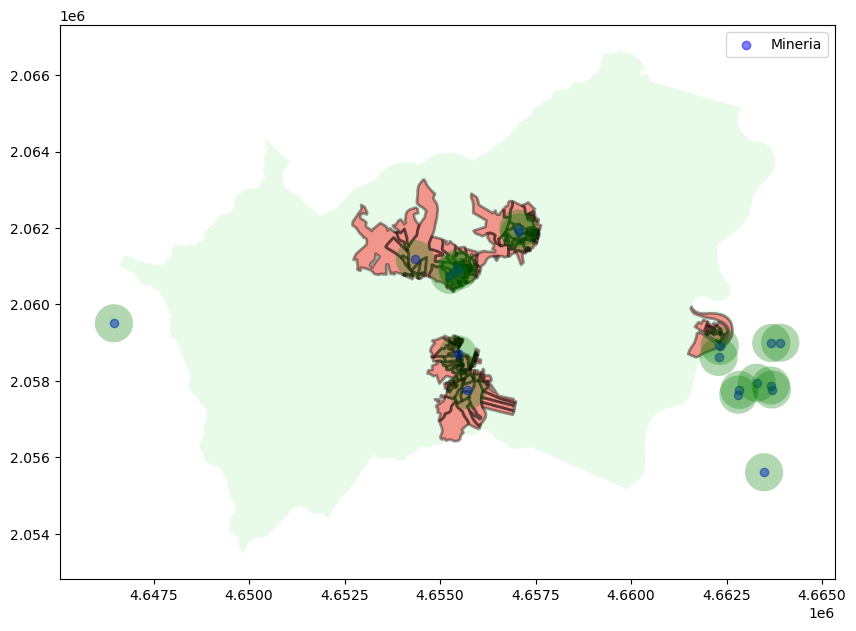

In [17]:
# Se hace un buffer para los puntos de mineria
mineria_buffered=miner.buffer(500)
# Los puntos con buffer son guardados como Geodataframe
mineria_buffered_gdf = gpd.GeoDataFrame(geometry=mineria_buffered)
# Se seleccionan solo aquellas parcelas que se intersecan con las zonas (buffer) de mineria
affected_parc = parc[parc.geometry.intersects(mineria_buffered_gdf.unary_union)]
# Se exporta el archivo a la carpeta results 
affected_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/miner_parc.geojson", driver="GeoJSON")
# Se grafican aquellos predios afectados junto a los puntos donde hay mineria
fig, ax = plt.subplots(figsize=(10, 10))
union.plot(ax=ax, color='lightgreen', alpha=0.2, label='Municipio')
affected_parc.plot(ax=ax, color='red', edgecolor='black', linewidth=2, alpha=0.4, label='Predios Afectados')
miner.plot(ax=ax, color='blue', alpha=0.5, label='Mineria')
mineria_buffered.plot(ax=ax, color='green', alpha=0.3, label='Buffer Zone')

plt.legend()
plt.show()

### Pendiente de cada parcela

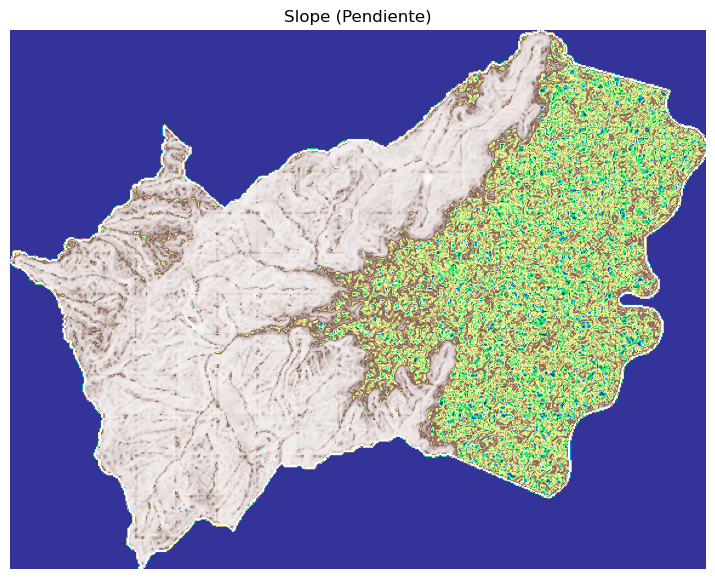

In [45]:
with rasterio.open(elev_path) as src:
    elev=src.read(1)
    dx, dy = np.gradient(elev)
    slope = np.arctan(np.sqrt(dx**2 + dy**2)) * (180 / np.pi)

    slopes = []

    if parc.crs != src.crs:
        parc = parc.to_crs(src.crs)

    for i,row in parc.iterrows():
        geom = row['geometry']
        geom_json = [geom.__geo_interface__]
        out_image, out_transform = mask(src, geom_json, crop=True)
        valid_values = out_image[~np.isnan(out_image)]
        avg_slope = valid_values.mean() if valid_values.size > 0 else None
        slopes.append(avg_slope)
slope_parc=parc
slope_parc['slope']=slopes
slope_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/slope_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(15, 7))
ax.imshow(slope, cmap='terrain')
ax.set_title("Slope (Pendiente)")
ax.axis('off')
plt.show()

### Vocación de cada parcela

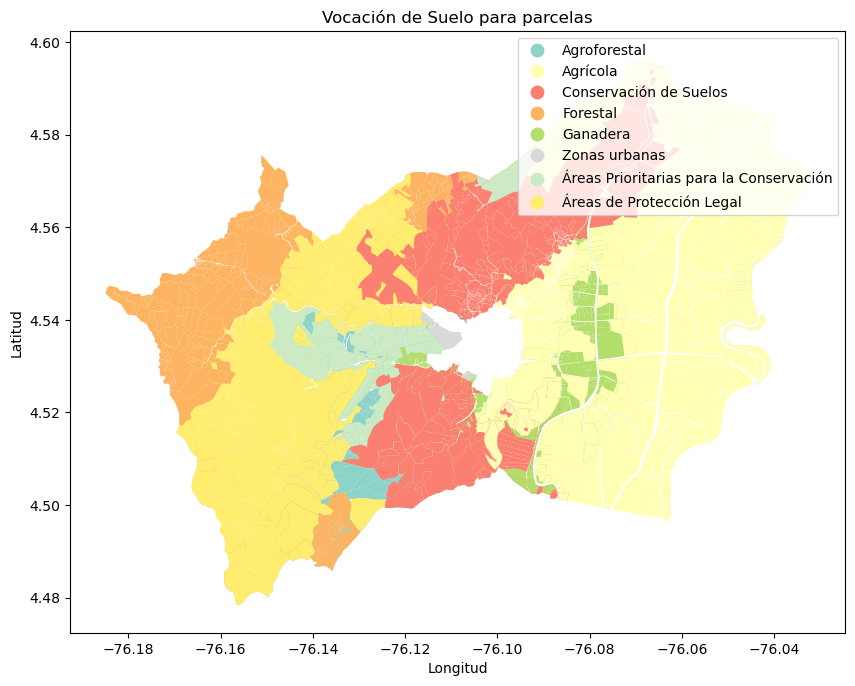

In [54]:
if parc.crs != voca.crs:
    voca = voca.to_crs(parc.crs)

voca_parc = gpd.sjoin(parc, voca, how="left", predicate="intersects")

voca_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/voca_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'Vocacion'
voca_parc.plot(column='Vocacion', ax=ax, legend=True,
                           cmap='Set3')  

# Agregar título y etiquetas si es necesario
ax.set_title("Vocación de Suelo para parcelas")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

# Mostrar el gráfico
plt.show()


### Propiedades edafoclimaticas de cada parcela

### Distancia a via principal de cada parcela